In [1]:
# Imports.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data_utils import CSVData
from dynamical_systems import linear_system, andronov_hopf
from nets import RK4N, RK4
from torch.utils.data.sampler import SubsetRandomSampler
from utils import euler, plot_phase_portrait, train_valid_loader

# 1. Linear system.

In [2]:
# Choose your network parameters.
input_size=2
num_param=1
hidden_size=20
h=1
num_hidden_layers=2

# Initialise the model.
model = RK4N(input_size, num_param, hidden_size, h, num_hidden_layers)

In [3]:
# Load data.
dataset = CSVData(csv_file_path='first_model.csv')
train_loader, val_loader = train_valid_loader(dataset)

In [4]:
# Loss & optimizer.
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# Losses
train_losses = []
val_losses = []

for epoch in range(10):  # loop over the dataset multiple times

    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, params, labels = data

            # forward + loss 
            outputs = model(inputs, params)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('[Epoch: %d] training loss: %.9f  validation loss: %.9f' %
            (epoch + 1, train_loss,val_loss))
    
            

print('Finished Training')

[Epoch: 1] training loss: 0.008283288  validation loss: 0.000028764
[Epoch: 2] training loss: 0.000016267  validation loss: 0.000012222
[Epoch: 3] training loss: 0.000011711  validation loss: 0.000009573
[Epoch: 4] training loss: 0.000004838  validation loss: 0.000003186
[Epoch: 5] training loss: 0.000003385  validation loss: 0.000003589
[Epoch: 6] training loss: 0.000003634  validation loss: 0.000003993
[Epoch: 7] training loss: 0.000003908  validation loss: 0.000003718
[Epoch: 8] training loss: 0.000003806  validation loss: 0.000003965
[Epoch: 9] training loss: 0.000004062  validation loss: 0.000004191
[Epoch: 10] training loss: 0.000004107  validation loss: 0.000004077
Finished Training


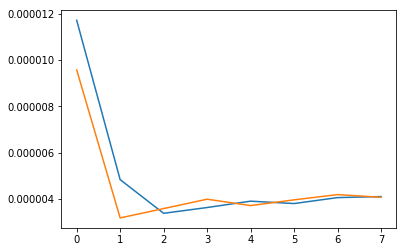

In [5]:
plt.plot(train_losses[2:])
plt.plot(val_losses[2:])

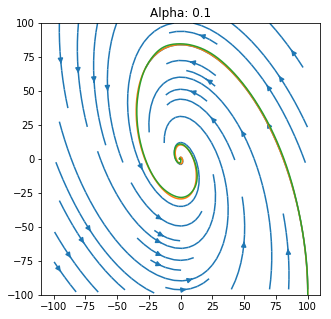

In [6]:
alpha = 0.1

plot_phase_portrait(linear_system, alpha, model, 100, [100,-100])

# 2. Andronov-Hopf system

In [2]:
# Choose your network parameters.
input_size=2
num_param=1
hidden_size=100
h=1
num_hidden_layers=3

# Initialise the model.
model = RK4N(input_size, num_param, hidden_size, h, num_hidden_layers)

In [3]:
# Load data.
dataset = CSVData(csv_file_path='second_model.csv')
train_loader, val_loader = train_valid_loader(dataset, bs=1000)

In [4]:
# Loss & optimizer.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

# Losses
train_losses = []
val_losses = []

for epoch in range(10):  # loop over the dataset multiple times

    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, params, labels = data

            # forward + loss 
            outputs = model(inputs, params)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('[Epoch: %d] training loss: %.9f  validation loss: %.9f' %
            (epoch + 1, train_loss,val_loss))
    
            

print('Finished Training')

[Epoch: 1] training loss: 0.000260393  validation loss: 0.000128399
[Epoch: 2] training loss: 0.000137859  validation loss: 0.000129272
[Epoch: 3] training loss: 0.000138006  validation loss: 0.000129164
[Epoch: 4] training loss: 0.000138057  validation loss: 0.000129962
[Epoch: 5] training loss: 0.000138178  validation loss: 0.000129289
[Epoch: 6] training loss: 0.000138191  validation loss: 0.000129215
[Epoch: 7] training loss: 0.000138243  validation loss: 0.000130147
[Epoch: 8] training loss: 0.000138358  validation loss: 0.000129648
[Epoch: 9] training loss: 0.000138331  validation loss: 0.000131057
[Epoch: 10] training loss: 0.000138408  validation loss: 0.000129911
Finished Training


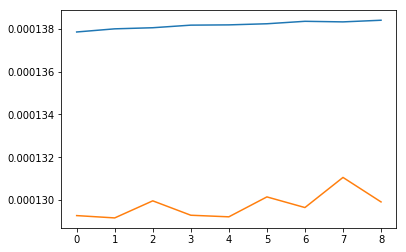

In [5]:
plt.plot(train_losses[1:])
plt.plot(val_losses[1:])

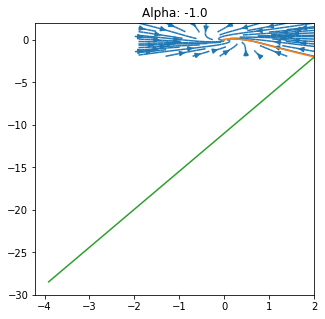

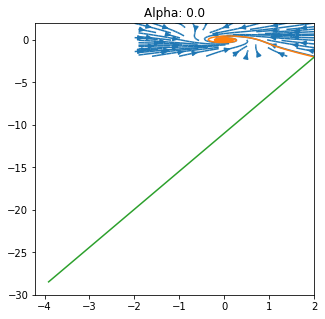

In [ ]:
plot_phase_portrait(andronov_hopf, -1.0, model, 2, [2,-2])
plot_phase_portrait(andronov_hopf,  0.0, model, 2, [2,-2])
plot_phase_portrait(andronov_hopf,  1.0, model, 2, [2,-2])

## Data Loader

In [3]:
import torch.utils.data as data
import csv

class DSData(data.Dataset):

    def __init__(self, csv_file_path='first_model.csv', input_size=2, num_param=1):
        self.points = []
        self.input_size=input_size
        self.num_param=num_param
        with open(csv_file_path) as f:
            reader = csv.reader(f, delimiter=',')
            for row in reader: 
                self.points.append([float(x) for x in row])

    def __getitem__(self, idx):
        point = self.points[idx]
        x = point[0:self.input_size]
        p = point[self.input_size:self.input_size+self.num_param]
        y = point[self.input_size+self.num_param:]
        return torch.FloatTensor(x), torch.FloatTensor(p), torch.FloatTensor(y)

    def __len__(self):
        return len(self.points)

In [4]:
from data_utils import 
from torch.utils.data import DataLoader

dataset = CSVData(csv_file_path='first_model.csv')
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
print(next(iter(dataloader)))

[tensor([[-61.7071,   2.0505],
        [ 97.7042,  49.5700],
        [ 66.5576,  80.9177],
        [-85.5570,  69.2499],
        [ 41.5902,  12.8507],
        [ 42.1248,  71.4536],
        [-66.2260,  58.1975],
        [ 49.7641, -32.9492],
        [-27.3687,  18.2244],
        [ 47.6866, -51.6678],
        [-70.6756,  93.7598],
        [ 71.3581, -61.6287],
        [ 64.8575, -92.3321],
        [ 52.4865, -72.4963],
        [ 15.9275, -42.0069],
        [-79.1633, -17.9070],
        [-98.6054, -56.7424],
        [-21.9050, -62.1553],
        [ 59.3237,  15.3978],
        [ 16.4118, -96.1166],
        [-72.2759,  78.9842],
        [ 27.1063,  34.7609],
        [ 12.6890,  73.5540],
        [ -6.2089, -68.1853],
        [-87.8894, -81.5389],
        [ 25.1938, -50.6394],
        [-98.2827, -94.7638],
        [ 76.2320,  37.8597],
        [-66.2325, -79.2530],
        [ 99.0310,  -8.8622],
        [ 18.7222,  69.1141],
        [ 29.0652,  42.3415],
        [ 71.5515, -60.4243],
        [

In [5]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)


for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.9f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.003137603
[1,  4000] loss: 0.000791752
[1,  6000] loss: 0.000353820
[1,  8000] loss: 0.000168892
[1, 10000] loss: 0.000097879
[2,  2000] loss: 0.000067051
[2,  4000] loss: 0.000055487
[2,  6000] loss: 0.000053786
[2,  8000] loss: 0.000056069
[2, 10000] loss: 0.000058195
[3,  2000] loss: 0.000059648
[3,  4000] loss: 0.000060938
[3,  6000] loss: 0.000061478
[3,  8000] loss: 0.000061784
[3, 10000] loss: 0.000061461
[4,  2000] loss: 0.000061350
[4,  4000] loss: 0.000061078
[4,  6000] loss: 0.000060801
[4,  8000] loss: 0.000060481
[4, 10000] loss: 0.000060286
[5,  2000] loss: 0.000060026
[5,  4000] loss: 0.000059954
[5,  6000] loss: 0.000059455
[5,  8000] loss: 0.000059477
[5, 10000] loss: 0.000059202
[6,  2000] loss: 0.000059059
[6,  4000] loss: 0.000058843
[6,  6000] loss: 0.000058567
[6,  8000] loss: 0.000058530
[6, 10000] loss: 0.000058337
[7,  2000] loss: 0.000058168
[7,  4000] loss: 0.000057884
[7,  6000] loss: 0.000057991
[7,  8000] loss: 0.000057617
[7, 10000] los

In [6]:
def flow(alpha, x, y):
    u = -alpha * x - alpha * y
    v = 0.25 * x
    return u,v

In [7]:
def euler(alpha, delta, y):
    u,v= flow(alpha, y[0], y[1])
    return y + delta * np.asarray([u, v])

In [11]:
def plot_face_portrait(alpha, index, grid, model):
    Y, X = np.mgrid[100:-100:20j, 100:-100:20j]
    U,V = flow(alpha, X, Y)
    trajectory1 = []
    trajectory2 = []
    y1 = [100, -100]
    y2 = [100, -100]
    for i in range(10000):
        trajectory1.append(y1)
        y1 = euler(alpha, 0.01, y1)
        trajectory2.append(y2)
        y2 = model(torch.FloatTensor(y2).unsqueeze(0), torch.FloatTensor([alpha]).unsqueeze(0)).tolist()[0]
    trajectory1 = np.asarray(trajectory1).T
    trajectory2 = np.asarray(trajectory2).T
    ax = plt.subplot(grid[index, 0])
    ax.streamplot(X, Y, U, V, density=[0.5, 1])
    ax.plot(trajectory1[0], trajectory1[1])
    ax.plot(trajectory2[0], trajectory2[1])
    ax.set_title('Alpha: ' + str(alpha))
    return

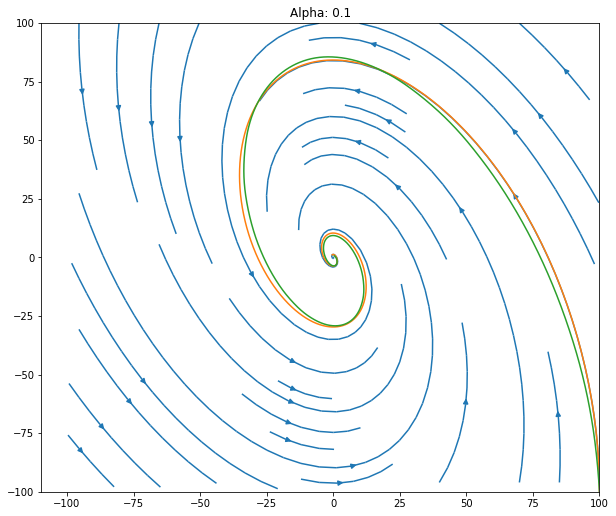

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

alphas = [0.1]

fig = plt.figure(figsize=(10, 50))
gs = gridspec.GridSpec(nrows=5, ncols=1)

for i in range(len(alphas)):
    plot_face_portrait(alphas[i], i, gs, model)

In [120]:
y = [1, 0.25]
alpha = 0.1
output = model(torch.FloatTensor(y).unsqueeze(0), torch.FloatTensor([alpha]).unsqueeze(0))
output.tolist()[0]

[0.9789198637008667, 0.274562805891037]

## Andronov-Hopf

In [29]:
from torch.utils.data import DataLoader

dataset_2 = DSData(csv_file_path='second_model_2.csv')
dataloader_2 = DataLoader(dataset_2, batch_size=100, shuffle=True)
print(next(iter(dataloader_2)))

[tensor([[ 3.7886e-01, -1.7302e+00],
        [ 1.3354e+00, -1.2343e+00],
        [ 1.0408e+00,  8.7868e-01],
        [-7.3378e-01, -1.5809e+00],
        [ 5.5445e-01,  1.6713e+00],
        [-1.1299e+00, -1.1228e+00],
        [ 1.7733e+00, -1.1467e+00],
        [ 1.8245e+00, -1.9487e+00],
        [ 1.0700e+00,  5.0952e-01],
        [-7.2853e-01,  1.1924e+00],
        [ 7.6288e-01, -6.2891e-02],
        [ 3.9070e-01,  1.1689e+00],
        [ 1.1858e+00,  1.8891e+00],
        [-1.7638e+00,  7.4503e-01],
        [-1.0297e+00, -8.4173e-01],
        [-6.5955e-01, -1.7592e+00],
        [ 5.5390e-01,  3.2928e-01],
        [ 5.3454e-01, -1.4769e+00],
        [-1.1730e+00, -7.9488e-01],
        [ 1.5605e+00,  6.8290e-01],
        [ 1.6208e+00,  1.4201e-01],
        [-1.4675e+00, -3.9787e-02],
        [ 9.4988e-01, -5.3082e-01],
        [ 3.6134e-01,  1.8799e+00],
        [-2.1006e-01, -1.2904e+00],
        [-1.4451e+00,  3.2426e-02],
        [-1.5967e+00,  6.5477e-01],
        [ 1.9974e-01,  1.62

In [30]:
# choose your network parameters
input_size=2
num_param=1
hidden_size=6
h=1

#Initialise the model
model_2=RK4(input_size, num_param, hidden_size, h)

# Test Data
X=torch.randn(20, input_size)
P=torch.randn(20, num_param)

output = model_2.forward(X, P)
output

tensor([[ 0.1952, -2.3296],
        [-1.9322, -0.7947],
        [ 0.8463, -0.3815],
        [-0.1382, -0.5732],
        [-0.2049, -0.2424],
        [ 0.4433, -1.1302],
        [ 0.1468,  0.0935],
        [ 0.6454, -0.5095],
        [ 1.9954, -0.5449],
        [ 0.5378,  0.0736],
        [-2.1578, -0.5631],
        [ 0.7992,  1.7437],
        [ 0.0193, -0.8639],
        [ 2.3679, -0.7046],
        [ 1.2399, -1.5584],
        [ 0.5089, -1.7387],
        [-0.0167, -2.6828],
        [-1.7380, -1.7589],
        [ 0.5189, -1.0311],
        [ 1.0677,  0.9901]], grad_fn=<AddBackward0>)

In [6]:
import torch.optim as optim


criterion2 = nn.MSELoss()
optimizer2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.9f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.000330734


KeyboardInterrupt: 

In [32]:
# Andronov-Hopf bifurcation
def andronov_hopf(x1, x2, a):
    dx1 = a*x1 - x2 - x1*(x1**2 + x2**2)
    dx2 = x1 + a*x2 - x2*(x1**2 + x2**2)
    return dx1, dx2

In [33]:
def euler(alpha, delta, y):
    u,v= andronov_hopf(y[0], y[1], alpha)
    return y + delta * np.asarray([u, v])

In [34]:
def plot_face_portrait(alpha, index, grid, model):
    Y, X = np.mgrid[2:-2:20j, 2:-2:20j]
    U,V = andronov_hopf(X, Y, alpha)
    trajectory1 = []
    trajectory2 = []
    y1 = [-2, 2]
    y2 = [-2, 2]
    for i in range(100000):
        #trajectory1.append(y1)
        #y1 = euler(alpha, 0.001, y1)
        trajectory2.append(y2)
        y2 = model_2(torch.FloatTensor(y2).unsqueeze(0), torch.FloatTensor([alpha]).unsqueeze(0)).tolist()[0]
    trajectory1 = np.asarray(trajectory1).T
    trajectory2 = np.asarray(trajectory2).T
    ax = plt.subplot(grid[index, 0])
    ax.streamplot(X, Y, U, V, density=[0.5, 1])
    print(trajectory2)
    #ax.plot(trajectory1[0], trajectory1[1])
    ax.plot(trajectory2[0], trajectory2[1])
    ax.set_title('Alpha: ' + str(alpha))
    return

[[-2.         -2.00142074 -2.00283647 ...  0.73150122  0.73150122
   0.73150122]
 [ 2.          1.99277484  1.98556197 ... -0.43791467 -0.43791467
  -0.43791467]]


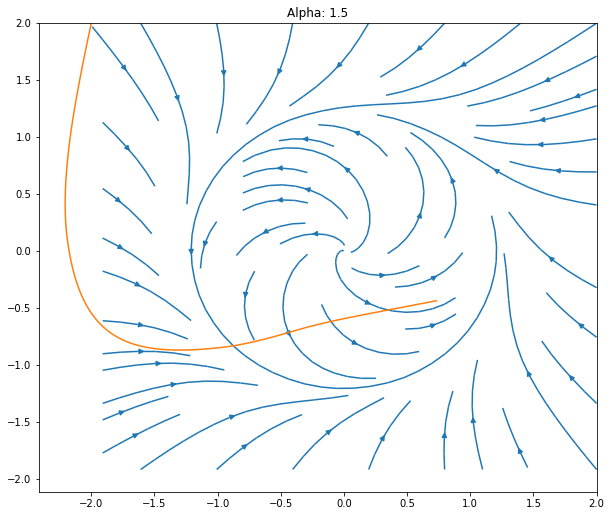

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

alphas = [1.5]

fig = plt.figure(figsize=(10, 50))
gs = gridspec.GridSpec(nrows=5, ncols=1)

for i in range(len(alphas)):
    plot_face_portrait(alphas[i], i, gs, model_2)

In [266]:
y = [-2, 2]
alpha = 0.1
output = model_2(torch.FloatTensor(y).unsqueeze(0), torch.FloatTensor([alpha]).unsqueeze(0))
output.tolist()[0]

[-1.9999992847442627, 2.0000038146972656]